<a href="https://colab.research.google.com/github/XxSupremeLordxX/ColabNotebooks/blob/main/GAN_Kaggle_Monet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [77]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.models import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

In [ ]:
import random
import os
import matplotlib.image as mpimg
from PIL import Image

In [78]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-3_98ddzr
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-3_98ddzr
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=bcc2a17769caa68e57e48595913473ea4e7073e645c210a5f3beff94be06f129
  Stored in directory: /tmp/pip-ephem-wheel-cache-qdqx0qrx/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [80]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
layer = InstanceNormalization(axis=-1)

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.7MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=a0695f03c7981fd1322451fff5e7863c47ab0ae26afe4ed62b5f44376b0c6117
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [ ]:
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list 

In [ ]:
!mkdir ./monet_gan
!cd ./monet_gan
!pwd

/content


In [ ]:
! kaggle competitions download -c gan-getting-started -p ./monet_gan/

 97% 356M/367M [00:05<00:00, 126MB/s]
100% 367M/367M [00:05<00:00, 74.8MB/s]


In [ ]:
!unzip ./monet_gan/gan-getting-started.zip

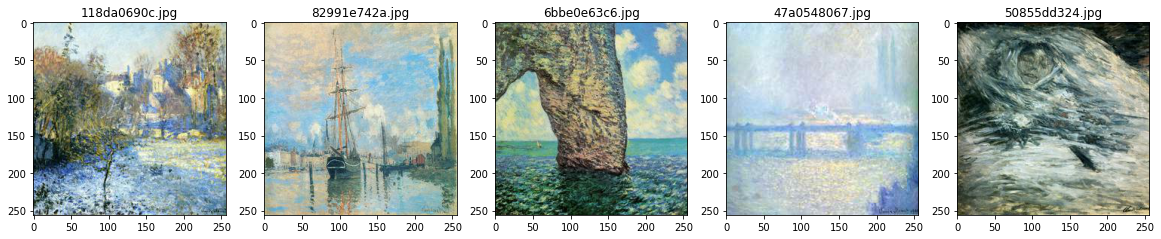

In [ ]:
plt.figure(figsize=(20,20))
for i in range(5):
    file = random.choice(os.listdir('./monet_jpg'))
    image_path= os.path.join(('./monet_jpg'), file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [ ]:
images = os.listdir('./../content/monet_jpg')

In [ ]:
images

In [ ]:
n = len(images)

In [ ]:
image_test = Image.open('./monet_jpg/'+random.choice(images))
image_test.size

(256, 256)

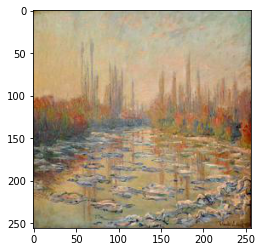

In [ ]:
plt.imshow(image_test)

In [ ]:
np.asarray(image_test).shape

(256, 256, 3)

In [ ]:
X = []
for image in images:
  cur_image = Image.open('./monet_jpg/'+image)
  X.append(np.asarray(cur_image))

In [ ]:
len(X)

300

In [ ]:
X_train = np.array(X)

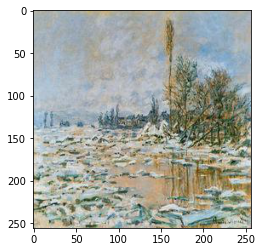

In [72]:
plt.imshow(X_train[random.randint(0,300)])

In [ ]:
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [76]:
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

In [ ]:
# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model